# THIS IS NOW OUTDATED - SEE ADMM_v2 
This documents the helper function creation, which have since been moved to A

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
from cvxpy import *
import os, sys, time
import matplotlib.pyplot as plt
%matplotlib inline

print("Current environment directory:" + sys.prefix)
print("System version: "+sys.version)
print("Current working directory: "+os.getcwd())

Current environment directory:/Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python/env/bin/..
System version: 2.7.12 (default, Aug 23 2016, 08:54:23) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
Current working directory: /Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python


In [5]:
inputData = pd.read_csv('../../Data/MatlabData/24h_MCC.csv',header=None).transpose()
print(inputData.shape)
inputData.head()

(14, 288)


,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,0.00000,0.000000,0.0000,0.00000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.00000,0.0000
1,4.68750,4.230400,12.8050,0.66288,1.0375,9.3794,1.94240,10.9600,10.5870,8.5702,...,5.9019,8.5661,6.0424,9.4003,10.9290,8.3888,12.7030,0.39474,1.84720,5.2799
2,13.90200,13.759000,13.3930,10.27400,17.5240,15.6490,7.46160,19.7190,16.6210,15.4820,...,13.6440,17.1500,8.4339,16.6970,12.1670,14.1980,17.2460,6.75450,8.40360,11.7000
3,0.35454,0.119540,9.6592,-2.71550,-5.5367,5.1335,-0.23246,4.9398,5.8953,4.4323,...,1.9912,3.0983,4.2619,5.1583,8.4051,4.3655,8.5165,-2.18410,-0.51273,1.8880
4,0.48719,-0.047588,8.6480,-2.49870,-3.9108,4.5292,-0.42730,5.1726,5.5714,3.6974,...,1.6627,3.6071,3.2016,4.0317,6.9284,4.0762,7.2162,-1.48800,-0.89017,1.6779


In [6]:
## Trim data down to a usable size
endBus = 5
endTimeIdx = 100
L = inputData.iloc[1:endBus,:endTimeIdx].values
(n,t) = L.shape       # t: time steps,  n: number of nodes
print(L.shape)

## Setting up for solving the problem

O = np.ones([n,n]) - np.eye(n)  # Off-diagonal matrix, dim n*n   (O := 1 1' - I)

# Tuning parameters: Weights in minimization
k1 = 1e-3  # This set is Kekatos' experimentally determined coefficients
k2 = 5e-4
k3 = 1e-2
k4 = 1e-1

(4, 100)


# DCOPF Background

Key components: 
- $N+1$ buses
- $L$ transmission lines, numbered $1, \dots , L$ and each line is designated with (from,to) nodes as $(m,n)$.

Vectors:
- Reactance for each line $x_l$
- Active Power injections from generators at each bus $p_n$, collected into vector $\tilde{\mathbf{p}}$
- Marginal generation costs $\mathbf{c}$ for the generator at each node
- Voltage phase at each bus, $\theta_n$ and corresponding vector $\tilde{\theta}$
- Line flows $f_l = (\theta_m - \theta_n)/ x_l$, collected into vector $\mathbf{f}$


Matrices:
- **Incidence matrix** of branches and buses  $\tilde{\mathbf{A}} \in \mathcal{R}^{L \times (N+1)}$. For each line $l$, there is a single entry with value 1 and another entry with value -1, specifically the entry for the from-column is 1, and the entry for the to-column is -1. Rows sum to zero.
- **Succeptance matrix** created by diagonalizing the reactances, $\mathbf{D} = \text{diag}\left( \{x_l^-1\}_{l=1}^L \right)$
- **Weighted Laplacian** of the network, $\tilde{\mathbf{B}} := \tilde{\mathbf{A}}^T \mathbf{D} \tilde{\mathbf{A}}$. 
   - The standard *Laplacian* matrix indicates the connectivity of network. The diagonals indicate the number of edges connected to a node, and the off-diagonal entries are negative 1 wherever the nodes are connected. Columns sum to 0.
   - The *weighted Laplacian* i indicates
   - The standard weighted laplacian is positive semidefinite, whereas the reduced grid laplacian (described below) is strictly positive definite.
   
Basic OPF: Given line limits $\underline{\mathbf{f}}, \bar{\mathbf{f}}$ and generator/consumer limits $\underline{\mathbf{p}}, \bar{\mathbf{p}}$ solve 

$$
\begin{align}
\left( \tilde{\mathbf{p}}^*, \tilde{\theta}^* \right) \; = \; \text{arg min}\quad & \mathbf{c}^T \tilde{\mathbf{p}} \\
\text{subject to} \quad & \underline{\mathbf{p}} \leq \tilde{\mathbf{p}} \leq \bar{\mathbf{p}}\\
& \tilde{\mathbf{p}} = \tilde{\mathbf{B}} \, \tilde{\boldsymbol{\theta}}\\
& \underline{\mathbf{f}}  \leq  \mathbf{D}\, \tilde{\mathbf{A}}\, \tilde{\boldsymbol{\theta}} \leq \bar{\mathbf{f}}
\end{align}
$$

This can be simplified by fixing the voltage angle at bus 1 and eliminating the first column of A, i.e. $\tilde{\mathbf{A}} = [a_1\; \mathbf{A}]$. Similarly, we define a subset of the power injections $\tilde{\mathbf{p}} = [p_1 \mathbf{p}], where we are still interested in the injections at bus 1.  Then the reduced grid Laplacian $\mathbf{B}=\mathbf{A}\mathbf{D}\mathbf{A}^T$ is strictly positive definite.

The problem can now be written as:
$$
\begin{align}
\tilde{\mathbf{p}}^* \;=\; \text{arg min}\quad & \mathbf{c}^T \tilde{\mathbf{p}} \\
\text{subject to} \quad & \underline{\mathbf{p}} \leq \tilde{\mathbf{p}} \leq \bar{\mathbf{p}}\\
& \tilde{\mathbf{p}}^T \mathbf{1} = 0 & \nu \\
& \underline{\mathbf{f}}  \leq  \mathbf{D}\, \mathbf{A} \, \mathbf{B}^{-1} \mathbf{p} \leq \bar{\mathbf{f}} & \underline{\mu},\bar{\mu}
\end{align}
$$

We are interested in the vector of LMPs, $\lambda$. The marginal cost of energy is $\nu$ (Kekatos uses $\lambda_0$), and we'll indicate the net shadow cost of congestion by $\mu = \underline{\mu} - \bar{\mu}$.  Then the LMP at each node is calculated as:

$$
\begin{align}
\text{LMP} & = &\text{MCE} &\quad+ &\text{MCC} &\quad+ &\text{MCL} \\
\left[\begin{array}{c}\lambda_1 \\ \mathbf{\lambda}\end{array}\right] &= &\nu \mathbf{1} &\quad+ &\left[\begin{array}{c}0 \\ \mathbf{B}^{-1}\, \mathbf{A} \, \mathbf{D} \mu \end{array}\right] &\quad+ &w
\end{align}
$$

# ADMM Formulation
Creates copies of the variables B and S for each term in the objective function, and then seeks to bring them into agreement by using an equality constraint.

$$
\begin{align}
\underset{S_1,S_2,B_1,B_2,B_3}{\text{minimize}} \quad & \frac{1}{2}||\mathbf{B}_1 \mathbf{L} - \mathbf{S}_2 ||_F^2 + \kappa_1 ||O \odot \mathbf{B}_2 ||_1 + \kappa_2 ||\mathbf{S}_1 ||_1 + \kappa_3 ||\mathbf{S}_2||_* - \kappa_4 \log |\mathbf{B}_3| \\
\text{subject to} \quad & O \odot \mathbf{B}_2 \leq 0 \\
& \mathbf{B}_3 \succ 0  \\
& \mathbf{B}_1 = \mathbf{B}_2 \; : \mathbf{Y}_{12}\\
& \mathbf{B}_1 = \mathbf{B}_3 \; : \mathbf{Y}_{13}\\
& \mathbf{S}_1 = \mathbf{S}_2 \; : \mathbf{Y}
\end{align}
$$

## First step: $\mathbf{B}_1, \mathbf{S}_1$
update $\mathbf{B}_1, \mathbf{S}_1$

### Update $\mathbf{B}_1$

$$
\mathbf{B_1}^{i+1} := (\mathbf{S}_2^i \mathbf{L}^T + \rho\mathbf{B}_2^i + \rho\mathbf{B}_3^i - \mathbf{Y}_{12}^i - \mathbf{Y}_{13}^i)(\mathbf{L}\mathbf{L}^T + 2 \rho \mathbf{I})^{-1}\\
$$

### Update $\mathbf{S}_1$
$$
\mathbf{S}_1^{i+1} := \mathcal{S}_{\kappa_2 / \rho} [\mathbf{S}_2^i - \frac{1}{\rho}\mathbf{Y}^i]
$$

where 

$$
\mathcal{S}_{\alpha}[x] := x \cdot \max\left\{1-\frac{\alpha}{|x|},0\right\}
$$
is applied to each of the elements in $x$ ...so in our case, this means that we need to take each element of the matrix $\mathbf{S}_2^i - \frac{1}{\rho}\mathbf{Y}^i$

## Second step: $\mathbf{B}_2, \mathbf{B}_3, \mathbf{S}_2$
update $\mathbf{B}_2, \mathbf{B}_3, \mathbf{S}_2$

### Update $\mathbf{B}_2$

$\mathbf{B}_2$ is updated element-wise with a soft threshold with a diagonal:

$$
\left[ \mathbf{B}_2^{i+1} \right]_{nm} := 
\begin{cases}
\left[ \mathbf{B}_1^{i+1} + \frac{1}{\rho}\mathbf{Y}_{12}^i \right]_{nm}, && n=m \\
\text{min}\left\{ \left[ \mathbf{B}_1^{i+1} + \frac{1}{\rho}\mathbf{Y}_{12}^i \right]_{nm} + \frac{\kappa_1}{\rho},0 \right\},  && n \neq m
\end{cases}
$$

### Update $\mathbf{B}_3$

Now $\mathbf{B}_3$ is updated using

$$
\mathbf{B}_3^{i+1} := \mathcal{T}_{\kappa_4 / \rho} \left[ \mathbf{B}_1^{i+1} + \frac{1}{\rho}\mathbf{Y}_{13}^i \right]
$$

where $\mathcal{T}_{\alpha}$ is a matrix related to the eigenvalue decomposition, where for some matrix $\mathbf{X}$ we can find a unitary matrix $\mathbf{U}$ and eigenvalues $\{s_k\}$ such that the eigenvalue decomposition is

$$
\frac{1}{2}(\mathbf{X}+\mathbf{X}^T) = \mathbf{U} \, \text{diag}(\{s_k\})\mathbf{U}^T
$$

Using these eigenvalues and unitary matrices composed from the eigenvectors, we can then define $\mathcal{T}_\alpha[\mathbf{X}]$ as 

$$
\mathcal{T}_\alpha[\mathbf{X}] := \mathbf{U} \, \text{diag}\left( \left\{ \frac{1}{2} \left( s_k + \sqrt{s_k^2 + 4\alpha} \right) \right\} \right) \mathbf{U}^T
$$

### Update $\mathbf{S}_2$

$$
\mathbf{S}_2^{i+1} := \frac{1}{\rho + 1} \cdot \mathcal{P}_{\kappa_3} \left[ \mathbf{B}_1^{i+1} \mathbf{L} + \rho \mathbf{S}_1^{i+1} + \mathbf{Y}^i \right]
$$

Where the operator $\mathcal{P}_{\alpha}[X]$ is related to both singular value decomposition and the soft-threshholding operator:

$$
\mathcal{P}_{\alpha}[X] := \mathbf{U} \, \text{diag}\left( \text{max} \{\sigma_i - \alpha ,0 \} \right) \mathbf{V}^T
$$


A *unitary* matrix has unit eigenvalues, and its transpose (specifically conjugate trnaspose or Hermitian transpose) is its invers.  $U \cdot U^T = I$

Singular Value Decomposition: For an $m \times n$ matrix, $\mathbf{X} := \mathbf{U} \, \text{diag}(\{ \sigma_i \} ) \mathbf{V}^T $  where $\mathbf{U}$ is a unitary square  $m \times m$ matrix, $\{ \sigma_i \}$ are the $m$ singular values (which are placed on the diagonal of an $m \times n$ matrix), and $\mathbf{V}$ is another unitary matrix of $n \times n$.  The columns of $U$ are the left-singular vectors, and the columns of $V$ are the right-singular vectors. 

The left-singular vectors are a set of orthonormal eigenvectors of $M \cdot M^*$ and the right-singular vectors are orthonormal eigenvectors of $M^* \cdot M$.  The non-zero singular values are the square roots of the non-zero eigenvalues of both $M^* \cdot M$ and $M \cdot M^*$.  

Remember, $\mathbf{S}$ is not a square matrix, so we cannot do eigenvalue decomposition but rather do singular value decomposition. 

## Lagrange Multiplier Update

Simple gradient ascent

$$
\begin{align}
\mathbf{Y}_{12}^{i+1} & := \mathbf{Y}_{12}^{i} + \rho(\mathbf{B}_1^{i+1} - \mathbf{B}_2^{i+1}) \\
\mathbf{Y}_{13}^{i+1} & := \mathbf{Y}_{13}^{i} + \rho(\mathbf{B}_1^{i+1} - \mathbf{B}_3^{i+1}) \\
\mathbf{Y}^{i+1} & := \mathbf{Y}^{i} + \rho(\mathbf{S}_1^{i+1} - \mathbf{S}_2^{i+1})
\end{align}
$$

In [7]:
######### ADMM HELPER FUNCTIONS #############

# First Step Update Functions, B1, S1
def updateB1(S2, B2, B3, Y12, Y13, L, rho):
    
    # Get all the typecasting out of the way
    S2, B2, B3, Y12, Y13, L = (np.matrix(x) for x in (S2, B2, B3, Y12, Y13, L))
    n = L.shape[0]
    
    out = (S2 * L.T + rho*B2 + rho*B3 - Y12 -Y13) * np.linalg.inv(L*L.T + 2*rho*np.eye(n))
    return out


def S_alpha(x,alpha):
    x = np.matrix(x)
    # Soft threshold operator
    alpha = float(alpha)
    max_op = np.maximum(1-alpha/np.abs(x),0)
    return np.multiply(x, max_op) #This guarantees elementwise multiplication

def updateS1(S2,Y,k2,rho):
    x     = S2 - 1./rho * Y
    alpha = k2 / rho
    return S_alpha(x,alpha)


## Second Step Update Functions: B2, B3, S2
def updateB2(B1_plus, Y12, k1, rho):
    # Inputs can either be matrices or np.ndarrays ...rho is a scalar
    n = Y12.shape[0]
    x = B1_plus + 1./rho * Y12
    x_out = np.minimum(x + k1/rho,0)           # This is the thresholding operator
    np.putmask(x_out,np.eye(n,dtype='bool'),x) # Place the original values of x in the diagonals of x_out
    return x_out
    
def T_alpha(s, U, alpha):
    #Eigenvalue scaling operator used in the computation of B3
    U = np.matrix(U) # Handle inputs

    dvec = 1./2*( s + np.sqrt(s**2 + 4*alpha) )
    d = np.matrix( np.diag(dvec) )
    return U * d * U.T

def updateB3(B1_plus, Y13, k4, rho):
    X = B1_plus + 1./rho * Y13
    X_temp = 1./2 *(X + X.T)
    (s,u) = np.linalg.eig(X_temp)
    return T_alpha( s , u , k4/rho )
    

def P_alpha(x, alpha):
    # Soft thresholding of singular values of matrix, used in computation of S2
    u,s,v = np.linalg.svd(x)
    # Handle inputs
    u = np.matrix(u)
    v = np.matrix(v)
    n = u.shape[0]
    d = np.matrix( np.zeros( [n, v.shape[0]]) ) # Zero matrix. We will later assign the diagonal of this

    # Compose the diagonal matrix
    dvec = np.maximum(s-alpha,0) # Soft threshold
    d[:n,:n] = np.diag(dvec)       # Create diagonals from soft-thresholded singular values
    return u * d * v
    
def updateS2(B1_plus, L, S1_plus, Y, k3, rho):
    B1_plus, L, S1_plus, Y = (np.matrix(x) for x in (B1_plus, L, S1_plus, Y))  #Typecast inputs
    
    x = B1_plus * L + rho * S1_plus + Y
    return 1./(rho+1.) * P_alpha(x,k3)

In [42]:
##############   ADMM IMPLEMENTATION   ###############

## Initialize B1,B2,B3, S1,S2, Y12,Y13,Y

B1,B2,B3, Y12,Y13 = [np.matrix(np.zeros([n,n]))]*5
S1,S2, Y = [np.matrix(np.zeros([n,t]))]*3

rho = 1e3

relTol = 1e-3
constraintFlag = True
i = 1

startTime = time.time()
## ADMM Iterations
while constraintFlag:

    ## First Step: Update B1, S1
    B1_plus = updateB1(S2, B2, B3, Y12, Y13, L, rho)
    S1_plus = updateS1(S2,Y,k2,rho)
    
    ## Second step: Update B2,B3,S2
    B2_plus = updateB2(B1_plus, Y12, k1, rho)
    B3_plus = updateB3(B1_plus, Y13, k4, rho)
    S2_plus = updateS2(B1_plus, L , S1_plus, Y, k3, rho)
    
    ## Lagrange Multiplier Update
    Y12_plus = Y12 + rho*(B1_plus - B2_plus)
    Y13_plus = Y13 + rho*(B1_plus - B3_plus)
    Y_plus   = Y   + rho*(S1_plus - S2_plus)

    ## Increment everything
    B1 = B1_plus
    B2 = B2_plus
    B3 = B3_plus
    S1 = S1_plus
    S2 = S2_plus
    Y12 = Y12_plus
    Y13 = Y13_plus
    Y = Y_plus
    

    b12constraint = np.abs(B1-B2).sum() / max(1e-9, min(np.abs(B1).sum(),np.abs(B2).sum()) )
    b13constraint = np.abs(B1-B3).sum() / max(1e-9, min(np.abs(B1).sum(),np.abs(B3).sum()) )
    sConstraint = np.abs(S1-S2).sum() /   max(1e-9, min(np.abs(S1).sum(),np.abs(S2).sum()) )
    if max(b12constraint, b13constraint, sConstraint) < relTol:
        constraintFlag = False
    i += 1
    
print("Finished %s iterations in %s seconds"%(i,time.time()-startTime))

B = np.average([B1,B2,B3],axis=0)

Finished 51 iterations in 0.111989974976 seconds


/Users/emunsing/GoogleDrive/Papers/GridStructureEstimation/Coding/Python/env/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide


# Centralized Solver in CvxPy

In [164]:
######### CENTRALIZED ALGORITHM IN CVXPY ###############

B = Semidef(n)
S = Variable(n,t)
obj = Minimize( 1/2. * sum_squares(B * L - S) +  # Least-squares fitting to data in L
               k1*norm(mul_elemwise(O, B), 1) +             # Make B sparse off-diagonal 
               k2*norm(S,1) +                  # Make S sparse
               k3*norm(S,'nuc') -              # Encourage a low-rank solution of S
               k4*log_det(B) )                 # Ensure B positive definite and nonzero

constraints = [mul_elemwise(O, B) <= 0]

prob = Problem(obj,constraints)

result = prob.solve(verbose=True, max_iters = 7000)
print("Solved!")

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 20810, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 7000, normalize = 1, scale = 1.00
Variables n = 11703, constraints m = 12598
Cones:	primal zero / dual free vars: 5820
	linear vars: 848
	soc vars: 402, soc blks: 1
	sd vars: 5516, sd blks: 4
	exp vars: 12, dual exp vars: 0
Setup time: 3.02e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  7.18e-02 
   100| 3.01e-01  7.17e-03  6.21e-04  8.91e-01  8.93e-01  1.37e-16  2.58e+00 
   200| 2.0

# Plotting Results

Inferred B matrix:
[[ 0.02 -0.01 -0.   -0.01]
 [-0.01  0.   -0.   -0.  ]
 [-0.   -0.    0.04 -0.03]
 [-0.01 -0.   -0.03  0.05]]


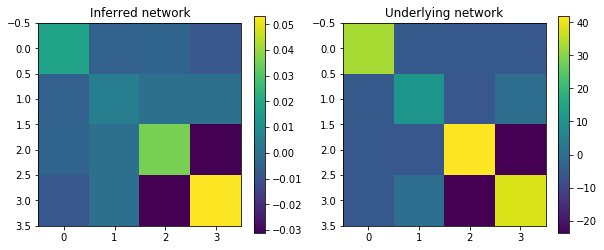

In [180]:
## Plot results and compare with actual

if (type(B) != np.ndarray):  # Take care of CVXpy version
    B = B.value

B_true = np.genfromtxt('../../Data/MatlabData/B_true_13bus.csv', delimiter=',')

print("Inferred B matrix:")
print(np.round(B,2))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(B)
plt.colorbar()
plt.title('Inferred network')

plt.subplot(1,2,2)
plt.imshow(B_true[0:endBus-1,0:endBus-1])
plt.colorbar()
plt.title('Underlying network')

## Notes on cvxpy:

**Expressions**: For any expression, can get size with (expr).size and value with (expr).value

## Notes on Numpy:
1-d numpy arrays have ambiguous dimensions: can be used as either row vector or column vector. 
- multiplication of arrays by default is elementwise.  Need to use np.dot() to get the true dot product.
- Np.dot will reorient vectors to get what it thinks is the desired result. 

### CVXPY and CVX use different p-norms for matrices!
CVX uses the induced matrix norm, while CvxPy treats the matrix as a vector, and uses the vector norm!

This means that the 1-norm in CVX is the maximum absolute column sum... while the 1-norm in CvxPy is the sum of the absolute values of the entries!

This is a ***huge*** difference! Need to look at how the paper intends to implement this.

**Kekatos uses the vector-norm, not the induced matrix norm!**
See page 2, last paragraph before section II.


In [211]:
## Debugging Matlab solvers

B_mat = np.genfromtxt('../Matlab/B_n4t25.csv', delimiter=',')
S_mat = np.genfromtxt('../Matlab/S_n4t25.csv', delimiter=',')

B_mat = np.matrix(B_mat)
S_mat = np.matrix(S_mat)

# obj = Minimize( 1/2. * sum_squares(B * L - S) +  # Least-squares fitting to data in L
#               k1*norm(mul_elemwise(O, B), 1) +             # Make B sparse off-diagonal 
#               k2*norm(S,1) +                  # Make S sparse
#               k3*norm(S,'nuc') -              # Encourage a low-rank solution of S
#               k4*log_det(B) )                 # Ensure B positive definite and nonzero


# Drawing Graphs 
Options: Graphviz software, NetworkX python package

Relevant matrices: for a graph with *n* nodes and *l* lines, 
- Admittance matrix: *l x n* matrix where for each row/line, columns that are connected are 1 (rows sum to 2, or 0 if directed)
- Degree matrix: Diagonal *n x n* matrix with the degree of each entry on the diagonal
- Adjacency matrix: *n x n* off-diagonal matrix where entries are 1 on the off-diagonal where nodes are connected. 0 entries on the diagonal. Can be formed by dotting the admittance matrix with itself, and zeroing the diagonal.
- Laplacian: Formed as (degree matrix - adjacency matrix) and has node degree on diagonal, and -1 on off-diagonals where there is a connection.
- weighted Laplacian: *n x n* matrix 
- reduced weighted Laplacian: what we have


The **Weighted Laplacian** entries are:
- Diagonal entries: sums of all the weights of lines connected to that node, i.e np.fill_diagonal(B,0); B.sum(axis=0)
- Note: For nodes which are connected to the reference bus, the difference between the diagonal entry and the column sum is the weight of the connection to the reference bus!
- Off-diagonal entries: negative weight of the line between the two nodes

Thus, the total number of lines is (half) the number of off-diagonal entries, plus connections with the reference bus.

We can programmatically recover the adjacency matrix, including the reference bus connections!

In [3]:
import networkx as nx

In [42]:
np.tril(B)a

array([[ 33.374 ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ -5.0513,  10.898 ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ -5.6715,  -5.8469,  42.011 ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ -5.7511,   0.    , -23.747 ,  38.239 ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,  -4.2574,  20.871 ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,  -4.8895,   0.    ,   0.    ,  19.657 ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,  -5.677 ,
          5.677 ,   0.    ,   0.    ,   0.    ,   

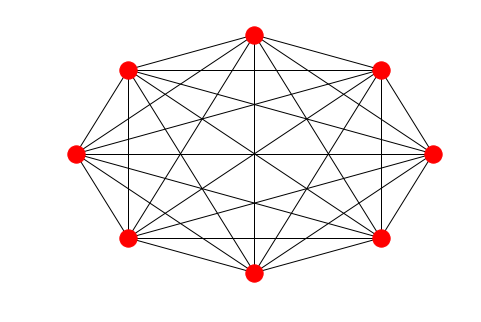

In [21]:
k35 = nx.complete_graph(8)
nx.draw_circular(k35)

In [30]:
# Load the true incidence matrix 

A_full = np.matrix(np.genfromtxt('../../Data/MatlabData/A_complete_true_13bus.csv', dtype=int,delimiter=',')) # l x n
A = np.matrix(np.genfromtxt('../../Data/MatlabData/A_true_13bus.csv', dtype=int,delimiter=','))  # l x n
abs_incidence = np.abs(A)

# Because we have a directed incidence matrix, A.T * A is actually the Laplacian!

B = np.matrix(np.genfromtxt('../../Data/MatlabData/B_true_13bus.csv', delimiter=','))  # n x n
D = np.matrix(np.genfromtxt('../../Data/MatlabData/D_true_13bus.csv', delimiter=','))  # l x l

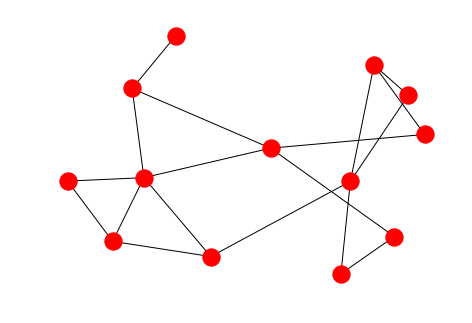

In [73]:
adj = np.dot(abs_incidence.T,abs_incidence)
np.fill_diagonal(adj,0)
G = nx.from_numpy_matrix(adj)
np.random.seed(1)  # The non-circular graphing tools position nodes randomly. This makes it repeatable.


nx.draw_spring(G)

In [19]:
# Simplest 3-bus network, 2 lines
A = np.matrix([[1,-1,0],[1,0,-1]])
D = np.matrix([[2,0],[0,3]])
B = A.T * D * A
B

matrix([[ 5, -2, -3],
        [-2,  2,  0],
        [-3,  0,  3]])

In [21]:
A.T * A * D

ValueError: shapes (3,3) and (2,2) not aligned: 3 (dim 1) != 2 (dim 0)

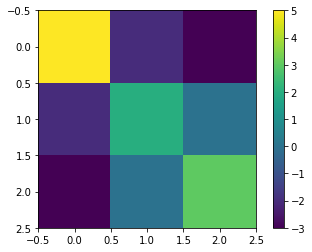

In [9]:
plt.imshow(B)
plt.colorbar()

In [25]:
A * A.T

matrix([[2, 1],
        [1, 2]])